# ベジエ曲線による輪郭線の近似　基礎考察



In [1]:
from sympy import *
from sympy.abc import a,b,c
init_session()
import numpy as np
%matplotlib inline
from sympy import var

# 輪郭線データその１
points = np.array([[115, 75], [106, 85],[99, 95],[95, 105],[94, 115],[92, 125],[92, 135],[93, 145],
 [96, 155],[104, 165],[115, 175],[129, 185], [151, 195],[171, 205],[181, 215],[184, 225],
 [185, 235],[185, 245],[184, 255],[183, 265],[182, 275],[181, 285],[179, 295],[177, 305]])
'''
# 輪郭線データその２
points = np.array([[159, 76],[164, 86], [174, 96], [182, 106], [189, 116],
 [193, 126], [198, 136], [201, 146], [204, 156], [206, 166], [207, 176], [206, 186], [205, 196],
 [204, 206], [202, 216], [200, 226], [198, 236], [194, 246], [191, 256], [189, 266], [189, 276],
 [189, 286], [189, 296]])'''

# 最小値が０になるように平行移動（不要かも）
xmin = points[:,0].min()
ymin = points[:,1].min()
points = points - [xmin,ymin]
xmin = points[:,0].min()
ymin = points[:,1].min()
xmax = points[:,0].max()
ymax = points[:,1].max()

# ベジエ曲線の仮のパラメータ
tindex = np.arange(len(points))/(len(points)-1)

IPython console for SymPy 1.2 (Python 3.6.6-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at http://docs.sympy.org/1.2/



# 方針

SymPy により式的にベジエ曲線を表現し、ナイーブな最小自乗法で点列にベジエ曲線をフィッティングする。

ベジエ曲線は４つの制御点で表される。それぞれがx座標、y座標を持つので、８つ方程式を立ててとけば良い。

普通の直線当てはめ同様に、自乗誤差を目的関数として定義し、それぞれの変数による偏微分が０とおけば８つの方程式が立てられる。

ベジエ曲線の４つの制御点のうち、両端の２つはベジエ曲線のセグメントの両端点でもあるので、それらが確定できるのならば、未知数は４つに減らせる。

In [2]:
# ３次のベジエの制御点 P0,P1,P2,P3にあたるシンボルと、それらのx,y座標用の変数を用意する
p3 = [Symbol('p3' + str(i)) for i in range(4)]
p3x,p3y =var('p3x:4'),var('p3y:4')
for i in range(4):
    p3[i] = Matrix([p3x[i],p3y[i]]) 
    print(p3[i])
t = symbols("t")
bez3 = (1-t)**3*p3[0] + 3*(1-t)**2*t*p3[1] + 3*(1-t)*t**2*p3[2] + t**3*p3[3]
bez3

Matrix([[p3x0], [p3y0]])
Matrix([[p3x1], [p3y1]])
Matrix([[p3x2], [p3y2]])
Matrix([[p3x3], [p3y3]])


⎡             3                    2         2                    3⎤
⎢p3x0⋅(-t + 1)  + 3⋅p3x1⋅t⋅(-t + 1)  + p3x2⋅t ⋅(-3⋅t + 3) + p3x3⋅t ⎥
⎢                                                                  ⎥
⎢             3                    2         2                    3⎥
⎣p3y0⋅(-t + 1)  + 3⋅p3y1⋅t⋅(-t + 1)  + p3y2⋅t ⋅(-3⋅t + 3) + p3y3⋅t ⎦

- ベジエ曲線は４つの制御点で定義される。そのうち２つP0,P3は両端点で曲線上の点であるが、残りのP1,P2は曲線上にはない。

(1) [TensorFlowを使って、点列を補間するベジェ曲線を求める（その２）](https://qiita.com/cnloni/items/5045b3e3a335cb933e23)  
(2) [Pythonで最小二乗法を使って指定の点を通るベジェ曲線を近似する](https://qiita.com/pashango2/items/6242b30c69524620979f)

- (1)の人はやってみせているのでできなくはないが、点列から４点の制御点すべてをフィッティングさせようとしても自由度が大きすぎるのでなかなか計算が大変である。  
理由は、
>- 各点 x、y の値を決めないといけないので、未知数が８つで、媒介変数 t によって表現される。  
> 通常最小自乗法等ではyの差を最小化するようにロス関数を設定するが、空間曲線のフィッティングは本来垂線の足の長さを最小化しないといけない。二次関数以上になると法線がある点を通るような曲線上の点は複数あり得るので簡単な一つの式に集約できない。yの差だけを考えるなら x座標と t を同一視できるので t が未知数でなくなるが、空間的な距離を誤差とすると、標本点が対応する t も未知数となってしまい、ますます解けない。
>- (2)では、t を固定して ４点を最適化するフェーズと、t を推定するフェーズに分け、交互に最適化をかけることでこの問題を解決している。

- (2) の方法では、１つの軸方法の差の総和だけを最小化の対象とし、両端点を固定つまり既知として解いているので未知数は２つのみ、おきまりの方法で、総和についてそれぞれの未知数で偏微分して２つの方程式をたて、それらを連立させて解く、という方法を取っている。

先に結論を書くと、（２）ではやはりダメで、（１）のやり方が必要なようである。

# フィッティング対象の点列

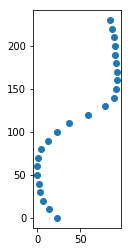

In [3]:
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(points)[:,0],np.array(points)[:,1]);

例えばこのデータはY方向は等間隔でとってあるので、それを t だと考えると、Y 方向の変化は当然次のようにリニアである。

24 24


(None, <matplotlib.collections.PathCollection at 0x11a466ac8>)

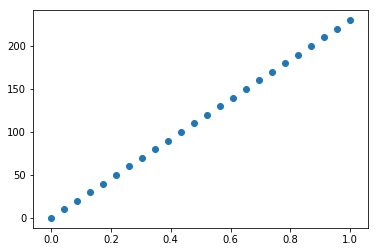

In [4]:
print(len(tindex),len(points)),plt.scatter(tindex,np.array(points)[:,1])

点列が等間隔の t によるサンプル点であると仮定し、横軸に t 、縦軸にxを取ってプロットすると次のようなグラフとなる。

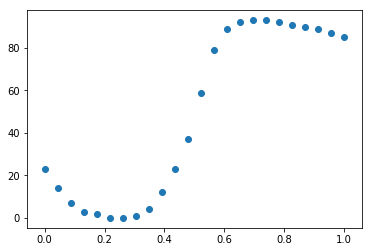

In [5]:
#plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(tindex,np.array(points)[:,0])

これを両端点は求める曲線の両端と一致するという前提のもとで解いてみよう。


```
bez = (1-t)**3*p[0] + 3*(1-t)**2*t*p[1] + 3*(1-t)*t**2*p[2] + t**3*p[3]
```


# 仮定にしたがって、両端の座標を入れて曲線の式を求める

各サンプル点のパラメータ t は y 座標に比例していると仮定
また、両端点で t = 0, t = 1 、すなわち、p0 = pints[0], p3 = points[-1]と仮定しているので、値を代入してしまう。

In [6]:
npoints = len(points)
bez3X = bez3.subs([[p3x[0],points[0][0]],[p3y[0],points[0][1]],[p3x[-1],points[-1][0]],[p3y[-1],points[-1][1]]])[0]
ft = (y - points[0][1])/(points[-1][1]-points[0][1]) #  y 座標を パラメータ t に変換する関数
bez3X, ft

ちょっと分かりにくいが、p3x1, p3x2 が未知数、t はパラメータで実は各サンプル点における t もまた未知数。そんなにたくさんの未知数では解けそうにないので、t = y/230 と仮定して解く。

# 誤差関数の定義
誤差はx座標の誤差を考えることにしたので、点P(x,y)とベジエ曲線上の点 (bez2[0],y)の間の誤差eを次のように定義

$$ e(x1,x2) = (x1-x2) ^{2}$$

Esum3X はその総和

In [7]:
x1,x2 = symbols('x1,x2')
e3X = (x1 - x2)**2
Esum3X = (1/2)*sum([e3X.subs([(x1,x_),(x2,bez3X.subs(t,ft.subs(y,y_)))]) for (x_,y_) in points])

In [8]:
# 代入した後にどんな式になっているかというと
expand(Esum3X)

In [9]:
# p3x1 と p3x2 で偏微分
d3_1 = diff(Esum3X,p3x1)
d3_2 = diff(Esum3X,p3x2)
d3_1,d3_2

In [10]:
# 連立させて解く
resX = solve([d3_1,d3_2],[p3x[1],p3x[2]])
resX

この結果をベジエの式に代入して、近似曲線を得る

In [11]:
bezresX = bez3X.subs([(p3x[1],resX[p3x1]),(p3x[2],resX[p3x2])]).subs(t,ft)
expand(bezresX)

結果を描いてみる。

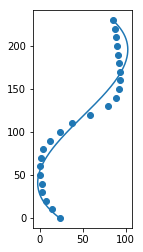

In [12]:
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(points)[:,0],np.array(points)[:,1]);
ploty = np.arange(0,ymax,1)
plotx = [bezresX.subs(y,i) for i in range(0,ymax)]
plt.plot(plotx,ploty)

# 考察

かなりずれてる

y と t が比例しているという仮定がやはりおかしいのではないか

それとこの方法ではグラフは書けても制御点がわからなくて気持ち悪い。

t は経路長に比例するのではないかということでやってみよう。

経路長は折れ線近似で近似することにしよう。

In [13]:
points1 = points[1:]
ds = points1-points[:-1] # サンプル点間の差分ベクトル
la = [np.sqrt(e[0]*e[0]+e[1]*e[1]) for e in ds] # サンプル点間の直線距離のリスト
axlength = np.sum(la) # 折れ線近似による経路長
tpara = np.zeros(len(points),np.float32)
tpara[0]=0.0
for i in range(len(la)):
    tpara[i+1] = tpara[i]+la[i]
tpara = tpara/axlength
tpara

array([0.        , 0.04740526, 0.09041634, 0.12836672, 0.16377853,
       0.1997124 , 0.23494844, 0.27036023, 0.30714774, 0.3522719 ,
       0.4046541 , 0.46527645, 0.5504282 , 0.62921846, 0.67904973,
       0.7158373 , 0.7512491 , 0.78648514, 0.821897  , 0.85730875,
       0.8927206 , 0.92813236, 0.96406615, 1.        ], dtype=float32)

# 再度チャレンジ

In [14]:
npoints = len(points)
bez3X = bez3.subs([[p3x[0],points[0][0]],[p3y[0],points[0][1]],[p3x[-1],points[-1][0]],[p3y[-1],points[-1][1]]])[0]
bez3X

In [15]:
# t への代入が前とは違う。折れ線近似から作った tpara の値を使う
x1,x2 = symbols('x1,x2')
e3X = (x1 - x2)**2
Esum3X = (1/2)*sum([e3X.subs([(x1,x_),(x2,bez3X.subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
expand(Esum3X)

In [16]:
# px1 と px2 で偏微分
d3x_1 = diff(Esum3X,p3x1)
d3x_2 = diff(Esum3X,p3x2)
d3x_1,d3x_2

In [17]:
# 連立させて解く
resX = solve([d3x_1,d3x_2],[p3x[1],p3x[2]])
resX

In [18]:
bezresX = bez3X.subs([(p3x[1],resX[p3x1]),(p3x[2],resX[p3x2])])
expand(bezresX)

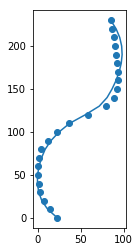

In [19]:
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(points)[:,0],np.array(points)[:,1]);
ploty = points[:,1]
plotx = [bezresX.subs(t,tp) for tp in tpara]
plt.plot(plotx,ploty)

# 考察

少し改善が見られるか？

yの方も同じことをやってみる。

In [20]:
npoints = len(points)
bez3Y = bez3.subs([[p3x[0],points[0][0]],[p3y[0],points[0][1]],[p3x[-1],points[-1][0]],[p3y[-1],points[-1][1]]])[1]
bez3Y

In [21]:
y1,y2 = symbols('y1,y2')
e3Y = (y1 - y2)**2
Esum3Y = (1/2)*sum([e3Y.subs([(y1,y_),(y2,bez3Y.subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
expand(Esum3Y)

In [22]:
# py1 と py2 で偏微分
d3y_1 = diff(Esum3Y,p3y1)
d3y_2 = diff(Esum3Y,p3y2)
d3y_1,d3y_2

In [23]:
# 連立させて解く
resy = solve([d3y_1,d3y_2],[p3y[1],p3y[2]])
resy

In [24]:
bezresY = bez3Y.subs([(p3y[1],resy[p3y1]),(p3y[2],resy[p3y2])])
expand(bezresY)

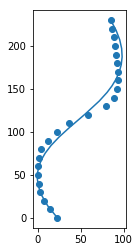

In [25]:
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(points)[:,0],np.array(points)[:,1]);
ploty = [bezresY.subs(t,tp) for tp in tpara]
plotx = [bezresX.subs(t,tp) for tp in tpara]
plt.plot(plotx,ploty)

# 考察

x のみ考えて最小化誤差を最小化した結果と y のみで最小化した結果が、双方を合わせた誤差の自乗を最適化した結果に等しいう保証はない。

やはり４変数でやってみよう。

In [26]:
x1,x2,y1,y2 = symbols('x1,x2,y1,y2')
e3x = (x1 - x2)**2
e3y = (y1 - y2)**2
Esum3X = (1/2)*sum([e3x.subs([(x1,x_),(x2,bez3X.subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
Esum3Y = (1/2)*sum([e3y.subs([(y1,y_),(y2,bez3Y.subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
Esum3 = Esum3X+Esum3Y
expand(Esum3)

In [27]:
# p3x1,p3x2, p3y1, p3y2 で偏微分
d3x_1 = diff(Esum3,p3x1)
d3x_2 = diff(Esum3,p3x2)
d3y_1 = diff(Esum3,p3y1)
d3y_2 = diff(Esum3,p3y2)
d3x_1,d3x_2,d3y_1,d3y_2

In [28]:
# 連立させて解く
res3 = solve([d3y_1,d3y_2,d3x_1,d3x_2],[p3x[1],p3x[2],p3y[1],p3y[2]])
res3

# 考察

本来パラメータを介して従属的であるはずのxとyが定数のパラメータで代用しているので独立になってしまい、まとめてもやはりx、y独立に解くのと同じになった。まあ当たり前か。

# ４次のベジエではどうか

In [29]:
from sympy import var
p4 = [Symbol('p4' + str(i)) for i in range(5)]
p4x,p4y =var('p4x:5'),var('p4y:5')
for i in range(5):
    p4[i] = Matrix([p4x[i],p4y[i]]) 
    print(p4[i])
t = symbols("t")
bez4 = (1-t)**3*p4[0] + 4*(1-t)**3*t*p4[1] + 6*(1-t)**2*t**2*p4[2]+4*(1-t)*t**3*p4[3] + t**4*p4[4]
bez4

Matrix([[p4x0], [p4y0]])
Matrix([[p4x1], [p4y1]])
Matrix([[p4x2], [p4y2]])
Matrix([[p4x3], [p4y3]])
Matrix([[p4x4], [p4y4]])


⎡             3                    3           2         2         3          
⎢p4x0⋅(-t + 1)  + 4⋅p4x1⋅t⋅(-t + 1)  + 6⋅p4x2⋅t ⋅(-t + 1)  + p4x3⋅t ⋅(-4⋅t + 4
⎢                                                                             
⎢             3                    3           2         2         3          
⎣p4y0⋅(-t + 1)  + 4⋅p4y1⋅t⋅(-t + 1)  + 6⋅p4y2⋅t ⋅(-t + 1)  + p4y3⋅t ⋅(-4⋅t + 4

          4⎤
) + p4x4⋅t ⎥
           ⎥
          4⎥
) + p4y4⋅t ⎦

In [30]:
npoints = len(points)
bez4 = bez4.subs([[p4x[0],points[0][0]],[p4y[0],points[0][1]],[p4x[-1],points[-1][0]],[p4y[-1],points[-1][1]]])
bez4

⎡                 3           2         2         3                  4        
⎢4⋅p4x1⋅t⋅(-t + 1)  + 6⋅p4x2⋅t ⋅(-t + 1)  + p4x3⋅t ⋅(-4⋅t + 4) + 85⋅t  + 23⋅(-
⎢                                                                             
⎢                        3           2         2         3                   4
⎣       4⋅p4y1⋅t⋅(-t + 1)  + 6⋅p4y2⋅t ⋅(-t + 1)  + p4y3⋅t ⋅(-4⋅t + 4) + 230⋅t 

      3⎤
t + 1) ⎥
       ⎥
       ⎥
       ⎦

In [31]:
x1,x2,y1,y2 = symbols('x1,x2,y1,y2')
e4x = (x1 - x2)**2
e4y = (y1 - y2)**2
Esum4X = (1/2)*sum([e4x.subs([(x1,x_),(x2,bez4[0].subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
Esum4Y = (1/2)*sum([e4y.subs([(y1,y_),(y2,bez4[1].subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
Esum4 = Esum4X+Esum4Y
expand(Esum4)

In [32]:
# p4x1,p4x2, p4x3,p4y1, p4y2,p4y3 で偏微分
d4x_1 = diff(Esum4,p4x1)
d4x_2 = diff(Esum4,p4x2)
d4x_3 = diff(Esum4,p4x3)
d4y_1 = diff(Esum4,p4y1)
d4y_2 = diff(Esum4,p4y2)
d4y_3 = diff(Esum4,p4y3)
d4x_1,d4x_2,d4x_3,d4y_1,d4y_2,d4y_3

In [33]:
# 連立させて解く
res4 = solve([d4y_1,d4y_2,d4y_3,d4x_1,d4x_2,d4x_3],[p4x[1],p4x[2],p4x[3],p4y[1],p4y[2],p4y[3]])
res4

In [34]:
bezres4X = bez4[0].subs([(p4x[1],res4[p4x1]),(p4x[2],res4[p4x2]),(p4x[3],res4[p4x3])])
bezres4Y = bez4[1].subs([(p4y[1],res4[p4y1]),(p4y[2],res4[p4y2]),(p4y[3],res4[p4y3])])
expand(bezres4X),expand(bezres4Y)

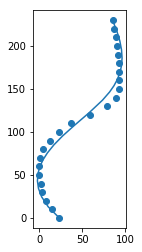

In [35]:
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(points)[:,0],np.array(points)[:,1]);
ploty = [bezres4Y.subs(t,tp) for tp in tpara]
plotx = [bezres4X.subs(t,tp) for tp in tpara]
plt.plot(plotx,ploty)

# 考察

四次ならもっとフィッティングできるはず。やはりパラメータも解かないとダメみたいだ。

# そもそも t は見積もれるのか？

定間隔でオンオフしてどうなるか試してみる。

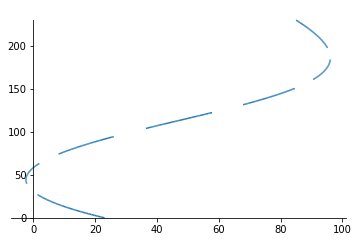

In [36]:
from sympy.plotting import plot, plot_implicit, plot_parametric
from sympy import symbols, sin, cos, pi
plot_parametric((bezres4X,bezres4Y,(t,0,0.1)),
                (bezres4X,bezres4Y,(t,0.15,0.25)),
                (bezres4X,bezres4Y,(t,0.3,0.4)),
                (bezres4X,bezres4Y,(t,0.45,0.55)),
                (bezres4X,bezres4Y,(t,0.6,0.7)),
                (bezres4X,bezres4Y,(t,0.75,0.85)),
                (bezres4X,bezres4Y,(t,0.9,1.0))
                )


この結果からわかることは、t を等間隔にしても、xもyも曲線に沿っても等間隔とはならないということ。
つまりサンプル点から t を推定することはかなり困難だということ。

# 両端点も変数としてフィッティングすればどうか

In [37]:
x1,x2,y1,y2= symbols('x1,x2,y1,y2')
e3x = (x1 - x2)**2
e3y = (y1 - y2)**2
Esum3X = (1/2)*sum([e3x.subs([(x1,x_),(x2,bez3[0].subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
Esum3Y = (1/2)*sum([e3y.subs([(y1,y_),(y2,bez3[1].subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])

In [38]:
# px0,px1, px2, px3, py1, py2,py3,py4 で偏微分
dx_0 = diff(Esum3X,p3x0)
dx_1 = diff(Esum3X,p3x1)
dx_2 = diff(Esum3X,p3x2)
dx_3 = diff(Esum3X,p3x3)
dy_0 = diff(Esum3Y,p3y0)
dy_1 = diff(Esum3Y,p3y1)
dy_2 = diff(Esum3Y,p3y2)
dy_3 = diff(Esum3Y,p3y3)
dx_0,dx_1,dx_2,dx_3,dy_0,dy_1,dy_2,dy_3

In [39]:
# 連立させて解く
resultX = solve([dx_0,dx_1,dx_2,dx_3],[p3x[0],p3x[1],p3x[2],p3x[3]])
resultY = solve([dy_0,dy_1,dy_2,dy_3],[p3y[0],p3y[1],p3y[2],p3y[3]])
resultX,resultY

In [40]:
bezresX = bez3[0].subs([(p3x[0],resultX[p3x0]),(p3x[1],resultX[p3x1]),(p3x[2],resultX[p3x2]),(p3x[3],resultX[p3x3])])
bezresY = bez3[1].subs([(p3y[0],resultY[p3y0]),(p3y[1],resultY[p3y1]),(p3y[2],resultY[p3y2]),(p3y[3],resultY[p3y3])])
expand(bezresX),expand(bezresY)

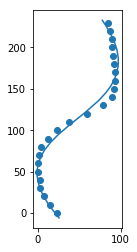

In [41]:
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(points)[:,0],np.array(points)[:,1]);
ploty = [bezresY.subs(t,tp) for tp in tpara]
plotx = [bezresX.subs(t,tp) for tp in tpara]
plt.plot(plotx,ploty)

# 考察

少しマシな感じがするが、まああまり変わらない。

# パラメータ推定

仮にフィッティングした曲線が正しいとして、各サンプル点に一番近い点を求め、そのパラメータを使ってフィッティングをやり直す。

一番近い点を解析的に解くのは無理だと思うので、十分細かく曲線状に点を取り、原始的に最も近いものを探して採用する。

In [42]:
# 各サンプル点に最も近い曲線上の点のパラメータ t を求める。
# まず、中央の点について、0.3 〜 0.7 の範囲で最も近い点を探す
frez = [bezresX,bezresY]
trange = np.arange(-0.1,1.1,0.01)
onpoints = [[s,frez[0].subs(t,s),frez[1].subs(t,s)] for s in trange]

tpara2 = np.zeros(len(points),np.float32) # 新しい 推定 t パラのリスト
def refineTpara(pl,stt,end,smin,smax):
    global tpara2,nmid
    if stt > end:
        return 
    else:
        nmid = int((end+stt)/2) # 担当中の中央のデータを抜き出す

        px,py = points[nmid]
        differ = onpoints[smin:smax].copy()
        differ = differ - np.array([0.0,px,py])
        distance = [x*x+y*y for _t,x,y in differ]
        nearest_i = np.argmin(distance)
        tpara2[nmid] = onpoints[smin+nearest_i][0]

        if nmid-stt >= 1 :
            refineTpara(pl,stt,nmid,smin,smin+nearest_i)
        if end-(nmid+1) >=1 :
            refineTpara(pl,nmid+1,end,smin+nearest_i,smax) 
    
refineTpara(points,0,len(points),0,len(onpoints))
diffpara = 0
for i in range(len(tpara)) :
    diffpara += np.sqrt((tpara[i]-tpara2[2])**2)
print(diffpara)

10.54592053219676


diffpara 0.16759602166712284
diffpara 0.10000000335276127
diffpara 0.07999998331069946
diffpara 0.03999999165534973
diffpara 0.030000030994415283
diffpara 0.040000006556510925
diffpara 0.03999996930360794
diffpara 0.03999997675418854
diffpara 0.030000045895576477
diffpara 0.010000050067901611
diffpara 0.019999980926513672
diffpara 0.019999980926513672
diffpara 0.020000040531158447
diffpara 0.019999980926513672
diffpara 0.019999980926513672
diffpara 0.0


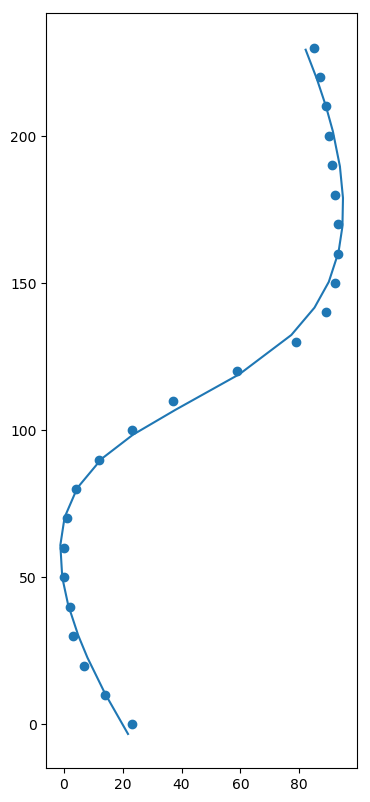

In [43]:
# 初期の推定パラメータの決定
points1 = points[1:]
ds = points1-points[:-1] # サンプル点間の差分ベクトル
la = [np.sqrt(e[0]*e[0]+e[1]*e[1]) for e in ds] # サンプル点間の直線距離のリスト
axlength = np.sum(la) # 折れ線近似による経路長
tpara = np.zeros(len(points),np.float32)
tpara[0]=0.0
for i in range(len(la)):
    tpara[i+1] = tpara[i]+la[i]
tpara = tpara/axlength

# ベジエ曲線の定義式
p3 = [Symbol('p3' + str(i)) for i in range(4)]
p3x,p3y =var('p3x:4'),var('p3y:4')
for i in range(4):
    p3[i] = Matrix([p3x[i],p3y[i]]) 
t = symbols("t")
bez3 = (1-t)**3*p3[0] + 3*(1-t)**2*t*p3[1] + 3*(1-t)*t**2*p3[2] + t**3*p3[3]

x1,x2,y1,y2= symbols('x1,x2,y1,y2')
e3x = (x1 - x2)**2
e3y = (y1 - y2)**2

def refineTpara(pl,stt,end,smin,smax):
        global tpara2,nmid
        if stt > end:
            return tpara2
        else:
            nmid = int((end+stt)/2) # 担当中の中央のデータを抜き出す

            px,py = points[nmid]
            differ = onpoints[smin:smax].copy()
            differ = differ - np.array([0.0,px,py])
            distance = [x*x+y*y for _t,x,y in differ]
            nearest_i = np.argmin(distance)
            tpara2[nmid] = onpoints[smin+nearest_i][0]

            if nmid-stt >= 1 :
                refineTpara(pl,stt,nmid,smin,smin+nearest_i)
            if end-(nmid+1) >=1 :
                refineTpara(pl,nmid+1,end,smin+nearest_i,smax) 

while True:
    Esum3X = (1/2)*sum([e3x.subs([(x1,x_),(x2,bez3[0].subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
    Esum3Y = (1/2)*sum([e3y.subs([(y1,y_),(y2,bez3[1].subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])

    # px0,px1, px2, px3, py1, py2,py3,py4 で偏微分
    dx_0 = diff(Esum3X,p3x0)
    dx_1 = diff(Esum3X,p3x1)
    dx_2 = diff(Esum3X,p3x2)
    dx_3 = diff(Esum3X,p3x3)
    dy_0 = diff(Esum3Y,p3y0)
    dy_1 = diff(Esum3Y,p3y1)
    dy_2 = diff(Esum3Y,p3y2)
    dy_3 = diff(Esum3Y,p3y3)
    dx_0,dx_1,dx_2,dx_3,dy_0,dy_1,dy_2,dy_3

    # 連立させて解く
    resultX = solve([dx_0,dx_1,dx_2,dx_3],[p3x[0],p3x[1],p3x[2],p3x[3]])
    resultY = solve([dy_0,dy_1,dy_2,dy_3],[p3y[0],p3y[1],p3y[2],p3y[3]])
    resultX,resultY

    # 解をベジエの式に代入
    bezresX = bez3[0].subs([(p3x[0],resultX[p3x0]),(p3x[1],resultX[p3x1]),(p3x[2],resultX[p3x2]),(p3x[3],resultX[p3x3])])
    bezresY = bez3[1].subs([(p3y[0],resultY[p3y0]),(p3y[1],resultY[p3y1]),(p3y[2],resultY[p3y2]),(p3y[3],resultY[p3y3])])
    expand(bezresX),expand(bezresY)

    # 各サンプル点に最も近い曲線上の点のパラメータ t を求める。
    # まず、中央の点について、0.3 〜 0.7 の範囲で最も近い点を探す
    frez = [bezresX,bezresY]
    trange = np.arange(-0.1,1.1,0.01)
    onpoints = [[s,frez[0].subs(t,s),frez[1].subs(t,s)] for s in trange]

    tpara2 = np.zeros(len(points),np.float32) # 新しい 推定 t パラのリスト
    refineTpara(points,0,len(points),0,len(onpoints))
    diffpara = 0
    for i in range(len(tpara)) :
        diffpara += np.sqrt((tpara[i]-tpara2[i])**2)
    print("diffpara",diffpara)
    tpara = tpara2
    if diffpara < 0.01:
        break
        
# 結果の描画
plt.figure(figsize=(7,10),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(points)[:,0],np.array(points)[:,1]);
ploty = [bezresY.subs(t,tp) for tp in tpara]
plotx = [bezresX.subs(t,tp) for tp in tpara]
plt.plot(plotx,ploty)

diffpara 0.08310644887387753
diffpara 0.03000006079673767
diffpara 0.020000040531158447
diffpara 0.009999990463256836


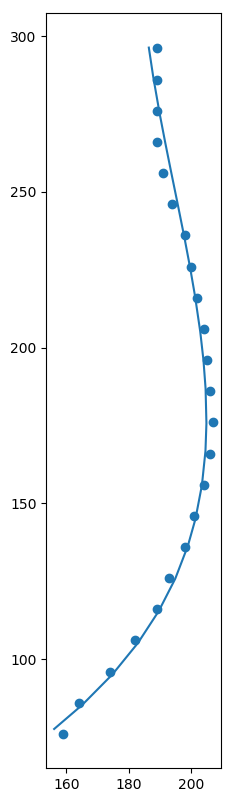

In [44]:
# 輪郭線データその２
points = np.array([[159, 76],[164, 86], [174, 96], [182, 106], [189, 116],
 [193, 126], [198, 136], [201, 146], [204, 156], [206, 166], [207, 176], [206, 186], [205, 196],
 [204, 206], [202, 216], [200, 226], [198, 236], [194, 246], [191, 256], [189, 266], [189, 276],
 [189, 286], [189, 296]])

# 初期の推定パラメータの決定
points1 = points[1:]
ds = points1-points[:-1] # サンプル点間の差分ベクトル
la = [np.sqrt(e[0]*e[0]+e[1]*e[1]) for e in ds] # サンプル点間の直線距離のリスト
axlength = np.sum(la) # 折れ線近似による経路長
tpara = np.zeros(len(points),np.float32)
tpara[0]=0.0
for i in range(len(la)):
    tpara[i+1] = tpara[i]+la[i]
tpara = tpara/axlength

# ベジエ曲線の定義式
p3 = [Symbol('p3' + str(i)) for i in range(4)]
p3x,p3y =var('p3x:4'),var('p3y:4')
for i in range(4):
    p3[i] = Matrix([p3x[i],p3y[i]]) 
t = symbols("t")
bez3 = (1-t)**3*p3[0] + 3*(1-t)**2*t*p3[1] + 3*(1-t)*t**2*p3[2] + t**3*p3[3]

x1,x2,y1,y2= symbols('x1,x2,y1,y2')
e3x = (x1 - x2)**2
e3y = (y1 - y2)**2

def refineTpara(pl,stt,end,smin,smax):
        global tpara2,nmid
        if stt > end:
            return tpara2
        else:
            nmid = int((end+stt)/2) # 担当中の中央のデータを抜き出す

            px,py = points[nmid]
            differ = onpoints[smin:smax].copy()
            differ = differ - np.array([0.0,px,py])
            distance = [x*x+y*y for _t,x,y in differ]
            nearest_i = np.argmin(distance)
            tpara2[nmid] = onpoints[smin+nearest_i][0]

            if nmid-stt >= 1 :
                refineTpara(pl,stt,nmid,smin,smin+nearest_i)
            if end-(nmid+1) >=1 :
                refineTpara(pl,nmid+1,end,smin+nearest_i,smax) 

while True:
    Esum3X = (1/2)*sum([e3x.subs([(x1,x_),(x2,bez3[0].subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])
    Esum3Y = (1/2)*sum([e3y.subs([(y1,y_),(y2,bez3[1].subs(t,t_))]) for (x_,y_),t_ in zip(points,tpara)])

    # px0,px1, px2, px3, py1, py2,py3,py4 で偏微分
    dx_0 = diff(Esum3X,p3x0)
    dx_1 = diff(Esum3X,p3x1)
    dx_2 = diff(Esum3X,p3x2)
    dx_3 = diff(Esum3X,p3x3)
    dy_0 = diff(Esum3Y,p3y0)
    dy_1 = diff(Esum3Y,p3y1)
    dy_2 = diff(Esum3Y,p3y2)
    dy_3 = diff(Esum3Y,p3y3)
    dx_0,dx_1,dx_2,dx_3,dy_0,dy_1,dy_2,dy_3

    # 連立させて解く
    resultX = solve([dx_0,dx_1,dx_2,dx_3],[p3x[0],p3x[1],p3x[2],p3x[3]])
    resultY = solve([dy_0,dy_1,dy_2,dy_3],[p3y[0],p3y[1],p3y[2],p3y[3]])
    resultX,resultY

    # 解をベジエの式に代入
    bezresX = bez3[0].subs([(p3x[0],resultX[p3x0]),(p3x[1],resultX[p3x1]),(p3x[2],resultX[p3x2]),(p3x[3],resultX[p3x3])])
    bezresY = bez3[1].subs([(p3y[0],resultY[p3y0]),(p3y[1],resultY[p3y1]),(p3y[2],resultY[p3y2]),(p3y[3],resultY[p3y3])])
    expand(bezresX),expand(bezresY)

    # 各サンプル点に最も近い曲線上の点のパラメータ t を求める。
    # まず、中央の点について、0.3 〜 0.7 の範囲で最も近い点を探す
    frez = [bezresX,bezresY]
    trange = np.arange(-0.1,1.1,0.01)
    onpoints = [[s,frez[0].subs(t,s),frez[1].subs(t,s)] for s in trange]

    tpara2 = np.zeros(len(points),np.float32) # 新しい 推定 t パラのリスト
    refineTpara(points,0,len(points),0,len(onpoints))
    diffpara = 0
    for i in range(len(tpara)) :
        diffpara += np.sqrt((tpara[i]-tpara2[i])**2)
    print("diffpara",diffpara)
    tpara = tpara2
    if diffpara < 0.01:
        break
        
# 結果の描画
plt.figure(figsize=(7,10),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(np.array(points)[:,0],np.array(points)[:,1]);
ploty = [bezresY.subs(t,tp) for tp in tpara]
plotx = [bezresX.subs(t,tp) for tp in tpara]
plt.plot(plotx,ploty)